# COGS 108 - EDA Checkpoint

# Names

- Chao-Li Wei
- Quinton Ramasamy
- Lauren Gomez
- Alexander G. Arias
- David Marquez

<a id='research_question'></a>
# Research Question

How does the number, favorite count, and retweet count of NBA players' political tweets affect their salary, on-court performance, and impact to the team during 2020-2021? <br>

# Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

In [3]:
df_2017 = pd.read_csv('data/year_2017.csv')
df_2018 = pd.read_csv('data/year_2018.csv')
df_2019 = pd.read_csv('data/year_2019.csv')
df_2020 = pd.read_csv('data/year_2020.csv')

In [4]:
df_2018.columns

Index(['Unnamed: 0', 'SEASON', 'AGE', 'TEAM', 'LEAGUE', 'POS', 'G', 'GS', 'MP',
       'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'SALARY', 'NAME'],
      dtype='object')

In [5]:
df_2017 = df_2017.drop(['Unnamed: 0'], axis=1)
df_2018 = df_2018.drop(['Unnamed: 0'], axis=1)
df_2019 = df_2019.drop(['Unnamed: 0'], axis=1)
df_2020 = df_2020.drop(['Unnamed: 0'], axis=1)

In [6]:
main_df = pd.concat([df_2017, df_2018, df_2019, df_2020], axis=0)

In [7]:
main_data = pd.read_csv('data/main_data.csv', index_col=0)
main_data

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,SALARY,NAME
7,2017-18,28.0,TOT,NBA,SF,50.0,14.0,14.3,1.8,4.3,...,1.8,1.9,0.6,0.2,0.1,0.4,1.1,5.2,"$1,974,159",Luke Babbitt
8,2017-18,28.0,ATL,NBA,SF,37.0,9.0,15.4,2.2,4.5,...,2.1,2.2,0.7,0.2,0.1,0.4,1.3,6.1,"$1,974,159",Luke Babbitt
9,2017-18,28.0,MIA,NBA,SF,13.0,5.0,11.2,0.8,3.6,...,1.0,1.2,0.4,0.1,0.2,0.3,0.5,2.5,"$1,974,159",Luke Babbitt
7,2017-18,28.0,ATL,NBA,SG,65.0,65.0,27.5,4.4,10.4,...,3.4,3.8,3.5,1.5,0.7,2.4,2.3,12.9,"$16,910,113",Kent Bazemore
8,2018-19,29.0,ATL,NBA,SG,67.0,35.0,24.5,4.1,10.3,...,3.3,3.9,2.3,1.3,0.6,1.8,2.5,11.6,"$18,089,887",Kent Bazemore
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,2018-19,25.0,CHI,NBA,SF,15.0,15.0,32.8,6.5,13.4,...,4.6,5.5,2.7,1.2,0.6,1.7,1.9,17.5,"$26,011,913",Jontay Porter
8,2019-20,26.0,CHI,NBA,SF,14.0,9.0,23.6,4.4,10.0,...,2.5,3.4,1.8,1.1,0.4,0.8,2.2,11.9,"$27,250,576",Jontay Porter
9,2020-21,27.0,TOT,NBA,"PF,SF",28.0,6.0,21.6,3.5,8.1,...,4.4,5.4,2.0,0.6,0.1,0.9,1.5,9.7,NaN,Jontay Porter
10,2020-21,27.0,CHI,NBA,SF,25.0,6.0,21.6,3.6,8.1,...,4.4,5.5,2.0,0.5,0.2,1.0,1.5,9.9,NaN,Jontay Porter


In [8]:
salaries_2021 = pd.read_csv('data/salaries_2021.csv', index_col=0)
salaries_2021

,Rk,Player,Tm,2020-21,2021-22,2022-23,2023-24,2024-25,2025-26,Signed Using,Guaranteed
0,1,Stephen Curry,GSW,"$43,006,362","$45,780,966",NaN,NaN,NaN,NaN,Bird Rights,"$88,787,328"
1,2,Russell Westbrook,WAS,"$41,358,814","$44,211,146","$47,063,478",NaN,NaN,NaN,Bird Rights,"$85,569,960"
2,3,Chris Paul,PHO,"$41,358,814","$44,211,146",NaN,NaN,NaN,NaN,Bird Rights,"$41,358,814"
3,4,John Wall,HOU,"$41,254,920","$44,310,840","$47,366,760",NaN,NaN,NaN,Bird Rights,"$85,565,760"
4,5,James Harden,BRK,"$40,824,000","$43,848,000","$46,872,000",NaN,NaN,NaN,Bird Rights,"$84,672,000"
...,...,...,...,...,...,...,...,...,...,...,...
558,509,Troy Williams,HOU,"$122,741","$122,741","$122,741",NaN,NaN,NaN,NaN,"$368,223"
559,510,Freddie Gillespie,TOR,"$116,903","$1,517,981",NaN,NaN,NaN,NaN,Minimum Salary,"$116,903"
560,511,Demetrius Jackson,BOS,"$92,857","$92,857","$92,857","$92,857",NaN,NaN,NaN,"$371,428"
561,512,Chimezie Metu,SAC,"$700,000","$1,762,796","$1,910,860",NaN,NaN,NaN,NaN,"$750,000"


In [9]:
salaries_2021.drop(salaries_2021[salaries_2021['2021-22'] == 'Salary'].index, inplace=True)
salaries_2021.drop(salaries_2021[salaries_2021['Rk'] == 'Rk'].index, inplace=True)
salaries_2021_only = salaries_2021.filter(['Player', '2020-21'])
salaries_2021_only.rename(columns={'2020-21' : 'SALARY', 'Player' : 'NAME'}, inplace=False)
salaries_2021_only.reset_index(drop=True, inplace=False)
salaries_2021_only

,Player,2020-21
0,Stephen Curry,"$43,006,362"
1,Russell Westbrook,"$41,358,814"
2,Chris Paul,"$41,358,814"
3,John Wall,"$41,254,920"
4,James Harden,"$40,824,000"
...,...,...
558,Troy Williams,"$122,741"
559,Freddie Gillespie,"$116,903"
560,Demetrius Jackson,"$92,857"
561,Chimezie Metu,"$700,000"


In [10]:
twitter_df_test1 = pd.read_pickle('data/twitter_political_1.pkl')
twitter_df_test2 = pd.read_pickle('data/twitter_political_2.pkl')
twitter_df_test3 = pd.read_pickle('data/twitter_political_3.pkl')
twitter_df_test4 = pd.read_pickle('data/twitter_political_4.pkl')
twitter_labeled = pd.read_csv('data/labeled_tweets.csv', index_col=0)

In [11]:
twitter_df = pd.concat([twitter_df_test1, twitter_df_test2, twitter_df_test3, twitter_df_test4], axis=0)

In [12]:
twitter_df.head()

,name,screen_name,followers_count,statuses_count,account_created_at,full_text,created_at,favorite_count,retweet_count,retweeted,id,possibly_sensitive,filtered_tweets,political_bools,num_political
0,Álex Abrines,alexabrines,54283.0,3118.0,2011-06-30 20:21:21+00:00,"[@BertranX @ganchetto @KaskyCascante Bueno, fa...","[2021-05-16 08:49:29+00:00, 2021-05-16 08:28:3...","[2, 3, 180, 186, 1, 3, 28, 41, 0, 52, 156, 263...","[0, 0, 1, 16, 0, 0, 1, 0, 1014, 1, 6, 26, 7, 7...","[False, False, False, False, False, False, Fal...","[1393851084444217344, 1393845803412819969, 139...","[nan, False, False, nan, nan, nan, False, Fals...","[[bertranx, ganchetto, kaskycascant, bueno, ,,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",27
1,Quincy Acy,QuincyAcy,33445.0,16231.0,2009-04-10 16:04:23+00:00,[RT @Ballislife: The NBA needs more players th...,"[2021-05-15 03:40:21+00:00, 2021-05-14 21:47:3...","[0, 0, 2, 1, 22, 1, 0, 259, 0, 0, 0, 0, 5, 9, ...","[541, 100, 0, 0, 0, 0, 3, 13, 593, 22, 7875, 1...","[False, False, False, False, False, False, Fal...","[1393410898027433986, 1393322139722334208, 139...","[False, nan, False, False, False, nan, False, ...","[[ballislif, :, nba, need, player, think, like...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, ...",141
2,Jaylen Adams,10jadams,4870.0,4721.0,2012-12-23 16:42:50+00:00,[RT @ComplexMusic: THE REAL IS BACK.\n\nJ. COL...,"[2021-05-14 05:48:18+00:00, 2021-05-09 21:17:0...","[0, 0, 0, 0, 0, 2, 0, 0, 0, 5, 0, 0, 0, 28, 0,...","[3794, 3, 32212, 6457, 7516, 0, 3000, 6630, 20...","[False, False, False, False, False, False, Fal...","[1393080711364681729, 1391502508426764292, 138...","[False, False, nan, False, False, nan, nan, na...","[[complexmus, :, real, back, ., j., cole, ., t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",84
3,Steven Adams,RealStevenAdams,216669.0,1642.0,2013-03-09 03:15:09+00:00,[RT @StationCDRKelly: Every day is #EarthDay e...,"[2021-04-22 20:42:30+00:00, 2021-02-18 20:00:0...","[0, 0, 0, 345, 54657, 0, 758, 0, 1648, 392, 58...","[812, 3321, 34, 10, 4306, 13692, 25, 10, 113, ...","[False, False, False, False, False, False, Fal...","[1385333211237031938, 1362492093051068416, 135...","[False, nan, nan, False, False, False, False, ...","[[stationcdrkelli, :, everi, day, earthday, ev...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",51
4,Bam Adebayo,Bam1of1,180603.0,14228.0,2012-04-17 01:29:18+00:00,[Just Sad Bro.... @DwyaneWade @spidadmitchell ...,"[2021-05-12 03:19:45+00:00, 2021-05-05 22:47:4...","[3573, 1000, 3060, 0, 17586, 0, 3756, 7299, 0,...","[208, 32, 392, 847, 935, 690, 546, 484, 41, 78...","[False, False, False, False, False, False, Fal...","[1392318550451363842, 1390075752629030912, 138...","[False, False, False, False, nan, False, False...","[[sad, bro, ...., dwyanewad, spidadmitchel, ht...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",70


In [13]:
# Positive Sentiment limit variable
def political_bools_final(list_in, positive):
    political_words_list = ['justice', 'political', 'blacklivesmatter', 'alllivesmatter', 'whitelivesmatter', 'bluelivesmatter', 'accountability', 'leftwing', 'rightwing', 'extremist', 'police-brutality', 'policereform',
'george-perry-floyd', 'minneapolis', 'derekchauvin', 'thomaslane', 'kueng', 'tou-thao', 'breonnataylor', 'bretthankison', 'mylescosgrove', 'joshuajaynes', 'elijahmcclain', 'nathanwoodyard', 'jasonrosenblatt',
'randyroedema', 'ahmaudarbery', 'gregorymcmichael', 'travismcmichael', 'williambryan', 'trayvonmartin', 'georgezimmerman', 'patriot', 'icantbreathe', 'saytheirname', 'sayhername', 'sayhisname', 'equality', 'equity',
'discrimination', 'killing', 'murder', 'assassination', 'mental-health', 'racial-profiling', 'stereotypes', 'racist', 'arrest', 'warrant', 'unfair', 'trump', 'biden', 'america', 'amerikkka',
'united-states', 'agenda', 'privilege', 'immunity', 'malfeasance', 'irresponsible', 'integrity', 'infringement', 'civil', 'violation', 'impunity', 'illegal', 'expose', 'dictatorship', 'authoritarian',
'corruption',  'allegation', 'law', 'illegal', 'congress', 'courts', 'trial', 'progressive', 'liberal', 'conservative', 'democrat', 'republican', 'democracy', 'snowflake', 'bootlicker', 'activism', 'protest', 'country', 
'social-justice', 'partisan', 'ideology', 'political', 'oppression', 'leadership', 'anarchy', 'conflict', 'establishment', 'derekchauvin', 'thomas-lane', 'guilty', 'innocent', 'debate', 'coronavirus', 'corona', 'covid',
'covid-19', 'chinese-virus', 'kung-flu', 'pandemic', 'hoax', 'covidiot', 'quarantine', 'mask', 'social-distance', 'lie', 'freedom', 'media', 'press', 'juneteenth', 'unconstitutional', 'empower', 'revolution', 'fascist', 'police',
'cops', 'pigs', 'force', 'terrorism', 'platform', 'power', 'crime', 'criminal-justice-system', 'communist', 'capitalist', 'liberties', 'abuse', 'poc', 'polarization', 'protect', 'violence', 'police', 'brutality', 'breonna', 'violate'
'violation', 'murdered', 'freedom', 'anti-mask', 'antimask', 'vaccine', 'vaccination', 'chauvin', 'government', 'govern', 'alleged', 'zimmerman', 'attack', 'slavery', 'segregated', 'segregation','Crow','brainwash',
'tyranny', 'CDC', 'president', 'totalitarian', 'woke', 'staywoke', 'power', 'fight', 'troops', 'diversity', 'allocate', 'refugee', 'masculinity', 'toxic', 'rape', 'immigration', 'society', 'corp', 'corporation', 'masculine', 'displaced', 'desiccation'
                           'repatriation', 'oppresive', 'administration', 'resettlement', 'defund', 'rayshard', 'resigned', 'resign', 'rittenhouse', 'kenosha', 'civility', 'presidential', 'capitol', 'riot', 'indigenous', 'arrested', 'privilege', 
                           'felony', 'weapon', 'war', 'siege', 'presidency', 'suppress', 'suppression', 'senator', 'congrssmen', 'reform', 'obama', 'michelleobama', 'barackobama', 'stopasianhate', 'stereotype', 'potus', 'clemency',
                           'justiceforbreonnataylor', 'justiceforgeorgefloyd', 'finance', 'financial', 'literacy', 'accountable', 'blackhistorymonth', 'sexuality', 'pridemonth', 'assault', 'officer', 'kneel', 'pledge', 'allegiance', 'womenshistorymonth',
                           'forthepeopleact', 'awareness', 'educate', 'education', 'israel', 'ramadan', 'eidmubarak', 'gaza', 'palestine', 'trayvon']
    
    political_stems = []
    analyser = SentimentIntensityAnalyzer()
    stemmer = SnowballStemmer('english')
    political_tweets_bool = []
    need_append = False
    for word in political_words_list:
        political_stems.append(stemmer.stem(word))
        political_tweets = []
    for i in range(0, len(list_in)):
        need_append = False
        if analyser.polarity_scores(' '.join(list_in[i]))['pos'] < positive:
            for token in list_in[i]:
                if token in political_stems:
                    need_append = True
        if need_append:
            political_tweets_bool.append(1)
        else:
            political_tweets_bool.append(0)
    return political_tweets_bool

In [14]:
# Positive Sentiment < .3
def political_bools_1(list_in):
    political_words_list = ['justice', 'political', 'blacklivesmatter', 'alllivesmatter', 'whitelivesmatter', 'bluelivesmatter', 'accountability', 'leftwing', 'rightwing', 'extremist', 'police-brutality', 'policereform',
'george-perry-floyd', 'minneapolis', 'derekchauvin', 'thomaslane', 'kueng', 'tou-thao', 'breonnataylor', 'bretthankison', 'mylescosgrove', 'joshuajaynes', 'elijahmcclain', 'nathanwoodyard', 'jasonrosenblatt',
'randyroedema', 'ahmaudarbery', 'gregorymcmichael', 'travismcmichael', 'williambryan', 'trayvonmartin', 'georgezimmerman', 'patriot', 'icantbreathe', 'saytheirname', 'sayhername', 'sayhisname', 'equality', 'equity',
'discrimination', 'killing', 'murder', 'assassination', 'mental-health', 'racial-profiling', 'stereotypes', 'racist', 'arrest', 'warrant', 'unfair', 'trump', 'biden', 'america', 'amerikkka',
'united-states', 'agenda', 'privilege', 'immunity', 'malfeasance', 'irresponsible', 'integrity', 'infringement', 'civil', 'violation', 'impunity', 'illegal', 'expose', 'dictatorship', 'authoritarian',
'corruption',  'allegation', 'law', 'illegal', 'congress', 'courts', 'trial', 'progressive', 'liberal', 'conservative', 'democrat', 'republican', 'democracy', 'snowflake', 'bootlicker', 'activism', 'protest', 'country', 
'social-justice', 'partisan', 'ideology', 'political', 'oppression', 'leadership', 'anarchy', 'conflict', 'establishment', 'derekchauvin', 'thomas-lane', 'guilty', 'innocent', 'debate', 'coronavirus', 'corona', 'covid',
'covid-19', 'chinese-virus', 'kung-flu', 'pandemic', 'hoax', 'covidiot', 'quarantine', 'mask', 'social-distance', 'lie', 'freedom', 'media', 'press', 'juneteenth', 'unconstitutional', 'empower', 'revolution', 'fascist', 'police',
'cops', 'pigs', 'force', 'terrorism', 'platform', 'power', 'crime', 'criminal-justice-system', 'communist', 'capitalist', 'liberties', 'abuse', 'poc', 'polarization', 'protect', 'violence', 'police', 'brutality', 'breonna', 'violate'
'violation', 'murdered', 'freedom', 'anti-mask', 'antimask', 'vaccine', 'vaccination', 'chauvin', 'government', 'govern', 'alleged', 'zimmerman', 'attack', 'slavery', 'segregated', 'segregation','Crow','brainwash',
'tyranny', 'CDC', 'president', 'totalitarian', 'woke', 'staywoke', 'power', 'fight', 'troops', 'diversity', 'allocate', 'refugee', 'masculinity', 'toxic', 'rape', 'immigration', 'society', 'corp', 'corporation', 'masculine', 'displaced', 'desiccation'
                           'repatriation', 'oppresive', 'administration', 'resettlement', 'defund', 'rayshard', 'resigned', 'resign', 'rittenhouse', 'kenosha', 'civility', 'presidential', 'capitol', 'riot', 'indigenous', 'arrested', 'privilege', 
                           'felony', 'weapon', 'war', 'siege', 'presidency', 'suppress', 'suppression', 'senator', 'congrssmen', 'reform', 'obama', 'michelleobama', 'barackobama', 'stopasianhate', 'stereotype', 'potus', 'clemency',
                           'justiceforbreonnataylor', 'justiceforgeorgefloyd', 'finance', 'financial', 'literacy', 'accountable', 'blackhistorymonth', 'sexuality', 'pridemonth', 'assault', 'officer', 'kneel', 'pledge', 'allegiance', 'womenshistorymonth',
                           'forthepeopleact', 'awareness', 'educate', 'education', 'israel', 'ramadan', 'eidmubarak', 'gaza', 'palestine', 'trayvon']
    
    political_stems = []
    analyser = SentimentIntensityAnalyzer()
    stemmer = SnowballStemmer('english')
    political_tweets_bool = []
    need_append = False
    for word in political_words_list:
        political_stems.append(stemmer.stem(word))
        political_tweets = []
    for i in range(0, len(list_in)):
        need_append = False
        if analyser.polarity_scores(' '.join(list_in[i]))['pos'] < .44:
            for token in list_in[i]:
                if token in political_stems:
                    need_append = True
        if need_append:
            political_tweets_bool.append(1)
        else:
            political_tweets_bool.append(0)
    return political_tweets_bool

In [15]:
# No Sentiment Analysis
def political_bools_2(list_in):
    political_words_list = ['justice', 'political', 'blacklivesmatter', 'alllivesmatter', 'whitelivesmatter', 'bluelivesmatter', 'accountability', 'leftwing', 'rightwing', 'extremist', 'police-brutality', 'policereform',
'george-perry-floyd', 'minneapolis', 'derekchauvin', 'thomaslane', 'kueng', 'tou-thao', 'breonnataylor', 'bretthankison', 'mylescosgrove', 'joshuajaynes', 'elijahmcclain', 'nathanwoodyard', 'jasonrosenblatt',
'randyroedema', 'ahmaudarbery', 'gregorymcmichael', 'travismcmichael', 'williambryan', 'trayvonmartin', 'georgezimmerman', 'patriot', 'icantbreathe', 'saytheirname', 'sayhername', 'sayhisname', 'equality', 'equity',
'discrimination', 'killing', 'murder', 'assassination', 'mental-health', 'racial-profiling', 'stereotypes', 'racist', 'arrest', 'warrant', 'unfair', 'trump', 'biden', 'america', 'amerikkka',
'united-states', 'agenda', 'privilege', 'immunity', 'malfeasance', 'irresponsible', 'integrity', 'infringement', 'civil', 'violation', 'impunity', 'illegal', 'expose', 'dictatorship', 'authoritarian',
'corruption',  'allegation', 'law', 'illegal', 'congress', 'courts', 'trial', 'progressive', 'liberal', 'conservative', 'democrat', 'republican', 'democracy', 'snowflake', 'bootlicker', 'activism', 'protest', 'country', 
'social-justice', 'partisan', 'ideology', 'political', 'oppression', 'leadership', 'anarchy', 'conflict', 'establishment', 'derekchauvin', 'thomas-lane', 'guilty', 'innocent', 'debate', 'coronavirus', 'corona', 'covid',
'covid-19', 'chinese-virus', 'kung-flu', 'pandemic', 'hoax', 'covidiot', 'quarantine', 'mask', 'social-distance', 'lie', 'freedom', 'media', 'press', 'juneteenth', 'unconstitutional', 'empower', 'revolution', 'fascist', 'police',
'cops', 'pigs', 'force', 'terrorism', 'platform', 'power', 'crime', 'criminal-justice-system', 'communist', 'capitalist', 'liberties', 'abuse', 'poc', 'polarization', 'protect', 'violence', 'police', 'brutality', 'breonna', 'violate'
'violation', 'murdered', 'freedom', 'anti-mask', 'antimask', 'vaccine', 'vaccination', 'chauvin', 'government', 'govern', 'alleged', 'zimmerman', 'attack', 'slavery', 'segregated', 'segregation','Crow','brainwash',
'tyranny', 'CDC', 'president', 'totalitarian', 'woke', 'staywoke', 'power', 'fight', 'troops', 'diversity', 'allocate', 'refugee', 'masculinity', 'toxic', 'rape', 'immigration', 'society', 'corp', 'corporation', 'masculine', 'displaced', 'desiccation'
                           'repatriation', 'oppresive', 'administration', 'resettlement', 'defund', 'rayshard', 'resigned', 'resign', 'rittenhouse', 'kenosha', 'civility', 'presidential', 'capitol', 'riot', 'indigenous', 'arrested', 'privilege', 
                           'felony', 'weapon', 'war', 'siege', 'presidency', 'suppress', 'suppression', 'senator', 'congrssmen', 'reform', 'obama', 'michelleobama', 'barackobama', 'stopasianhate', 'stereotype', 'potus', 'clemency',
                           'justiceforbreonnataylor', 'justiceforgeorgefloyd', 'finance', 'financial', 'literacy', 'accountable', 'blackhistorymonth', 'sexuality', 'pridemonth', 'assault', 'officer', 'kneel', 'pledge', 'allegiance', 'womenshistorymonth',
                           'forthepeopleact', 'awareness', 'educate', 'education', 'israel', 'ramadan', 'eidmubarak', 'gaza', 'palestine', 'trayvon']
    
    political_stems = []
    analyser = SentimentIntensityAnalyzer()
    stemmer = SnowballStemmer('english')
    political_tweets_bool = []
    need_append = False
    for word in political_words_list:
        political_stems.append(stemmer.stem(word))
        political_tweets = []
    for i in range(0, len(list_in)):
        need_append = False
        if analyser.polarity_scores(' '.join(list_in[i]))['compound'] != -5:
            for token in list_in[i]:
                if token in political_stems:
                    need_append = True
        if need_append:
            political_tweets_bool.append(1)
        else:
            political_tweets_bool.append(0)
    return political_tweets_bool

In [16]:
# Compound sentiment != 0
def political_bools_3(list_in):
    political_words_list = ['justice', 'political', 'blacklivesmatter', 'alllivesmatter', 'whitelivesmatter', 'bluelivesmatter', 'accountability', 'leftwing', 'rightwing', 'extremist', 'police-brutality', 'policereform',
'george-perry-floyd', 'minneapolis', 'derekchauvin', 'thomaslane', 'kueng', 'tou-thao', 'breonnataylor', 'bretthankison', 'mylescosgrove', 'joshuajaynes', 'elijahmcclain', 'nathanwoodyard', 'jasonrosenblatt',
'randyroedema', 'ahmaudarbery', 'gregorymcmichael', 'travismcmichael', 'williambryan', 'trayvonmartin', 'georgezimmerman', 'patriot', 'icantbreathe', 'saytheirname', 'sayhername', 'sayhisname', 'equality', 'equity',
'discrimination', 'killing', 'murder', 'assassination', 'mental-health', 'racial-profiling', 'stereotypes', 'racist', 'arrest', 'warrant', 'unfair', 'trump', 'biden', 'america', 'amerikkka',
'united-states', 'agenda', 'privilege', 'immunity', 'malfeasance', 'irresponsible', 'integrity', 'infringement', 'civil', 'violation', 'impunity', 'illegal', 'expose', 'dictatorship', 'authoritarian',
'corruption',  'allegation', 'law', 'illegal', 'congress', 'courts', 'trial', 'progressive', 'liberal', 'conservative', 'democrat', 'republican', 'democracy', 'snowflake', 'bootlicker', 'activism', 'protest', 'country', 
'social-justice', 'partisan', 'ideology', 'political', 'oppression', 'leadership', 'anarchy', 'conflict', 'establishment', 'derekchauvin', 'thomas-lane', 'guilty', 'innocent', 'debate', 'coronavirus', 'corona', 'covid',
'covid-19', 'chinese-virus', 'kung-flu', 'pandemic', 'hoax', 'covidiot', 'quarantine', 'mask', 'social-distance', 'lie', 'freedom', 'media', 'press', 'juneteenth', 'unconstitutional', 'empower', 'revolution', 'fascist', 'police',
'cops', 'pigs', 'force', 'terrorism', 'platform', 'power', 'crime', 'criminal-justice-system', 'communist', 'capitalist', 'liberties', 'abuse', 'poc', 'polarization', 'protect', 'violence', 'police', 'brutality', 'breonna', 'violate'
'violation', 'murdered', 'freedom', 'anti-mask', 'antimask', 'vaccine', 'vaccination', 'chauvin', 'government', 'govern', 'alleged', 'zimmerman', 'attack', 'slavery', 'segregated', 'segregation','Crow','brainwash',
'tyranny', 'CDC', 'president', 'totalitarian', 'woke', 'staywoke', 'power', 'fight', 'troops', 'diversity', 'allocate', 'refugee', 'masculinity', 'toxic', 'rape', 'immigration', 'society', 'corp', 'corporation', 'masculine', 'displaced', 'desiccation'
                           'repatriation', 'oppresive', 'administration', 'resettlement', 'defund', 'rayshard', 'resigned', 'resign', 'rittenhouse', 'kenosha', 'civility', 'presidential', 'capitol', 'riot', 'indigenous', 'arrested', 'privilege', 
                           'felony', 'weapon', 'war', 'siege', 'presidency', 'suppress', 'suppression', 'senator', 'congrssmen', 'reform', 'obama', 'michelleobama', 'barackobama', 'stopasianhate', 'stereotype', 'potus', 'clemency',
                           'justiceforbreonnataylor', 'justiceforgeorgefloyd', 'finance', 'financial', 'literacy', 'accountable', 'blackhistorymonth', 'sexuality', 'pridemonth', 'assault', 'officer', 'kneel', 'pledge', 'allegiance', 'womenshistorymonth',
                           'forthepeopleact', 'awareness', 'educate', 'education', 'israel', 'ramadan', 'eidmubarak', 'gaza', 'palestine', 'trayvon']
    
    political_stems = []
    analyser = SentimentIntensityAnalyzer()
    stemmer = SnowballStemmer('english')
    political_tweets_bool = []
    need_append = False
    for word in political_words_list:
        political_stems.append(stemmer.stem(word))
        political_tweets = []
    for i in range(0, len(list_in)):
        need_append = False
        if analyser.polarity_scores(' '.join(list_in[i]))['compound'] != 0:
            for token in list_in[i]:
                if token in political_stems:
                    need_append = True
        if need_append:
            political_tweets_bool.append(1)
        else:
            political_tweets_bool.append(0)
    return political_tweets_bool

In [17]:
y_true = pd.concat([twitter_labeled['Jamal Crawford'], twitter_labeled['Wenyen Gabriel'], twitter_labeled['Marquese Chriss'], 
                   twitter_labeled['Harrison Barnes'], twitter_labeled['Solomon Hill'], twitter_labeled['Garrett Temple'], 
                   twitter_labeled['Enes Kanter'], twitter_labeled['Ekpe Udoh'], twitter_labeled['Evan Turner'], 
                   twitter_labeled['Chris Paul'], twitter_labeled['Tobias Harris'], twitter_labeled['Carmelo Anthony'], 
                   twitter_labeled['LeBron James']])
y_true = list(y_true)

In [18]:
index_list = [158, 226, 131, 35, 292, 608, 356, 628, 626, 512, 270, 22, 330]
y_pred_1 = []
y_pred_2 = []
y_pred_3 = []
for index in index_list:
    curr_100 = twitter_df['filtered_tweets'].iloc[index][0:100]
    curr_bools_1 = political_bools_1(curr_100)
    curr_bools_2 = political_bools_2(curr_100)
    curr_bools_3 = political_bools_3(curr_100)
    y_pred_1 += curr_bools_1
    y_pred_2 += curr_bools_2
    y_pred_3 += curr_bools_3
confuse_matrix_1 = confusion_matrix(y_true, y_pred_1)
confuse_matrix_2 = confusion_matrix(y_true, y_pred_2)
confuse_matrix_3 = confusion_matrix(y_true, y_pred_3)
target_names = ['Non-Political', 'Political']

In [19]:
def test_input_pos(input_nums):
    index_list = [158, 226, 131, 35, 292, 608, 356, 628, 626, 512, 270, 22, 330]
    f1_scores = []
    for num in input_nums:
        y_pred = []
        for index in index_list:
            curr_100 = twitter_df['filtered_tweets'].iloc[index][0:100]
            curr_bools = political_bools_final(curr_100, num)
            y_pred += curr_bools
        f1_scores.append(f1_score(y_true, y_pred))
    f1_dict = {input_nums[i]: f1_scores[i] for i in range(len(input_nums))}
    return f1_dict

In [20]:
input_nums = [.42, .425, .43, .435, .44, .445, .45, .455, .46, .465, .47, .475, .48, .485, .49, .495, .5, .505, .51, .515, .52]
test_input_pos(input_nums)

{0.42: 0.7142857142857143,
 0.425: 0.7121661721068249,
 0.43: 0.7159763313609468,
 0.435: 0.7159763313609468,
 0.44: 0.7159763313609468,
 0.445: 0.7159763313609468,
 0.45: 0.7138643067846608,
 0.455: 0.7138643067846608,
 0.46: 0.7138643067846608,
 0.465: 0.7138643067846608,
 0.47: 0.7117647058823529,
 0.475: 0.7117647058823529,
 0.48: 0.7117647058823529,
 0.485: 0.7117647058823529,
 0.49: 0.7117647058823529,
 0.495: 0.7117647058823529,
 0.5: 0.7117647058823529,
 0.505: 0.7117647058823529,
 0.51: 0.7117647058823529,
 0.515: 0.7096774193548389,
 0.52: 0.7096774193548389}

f1_score: 0.716


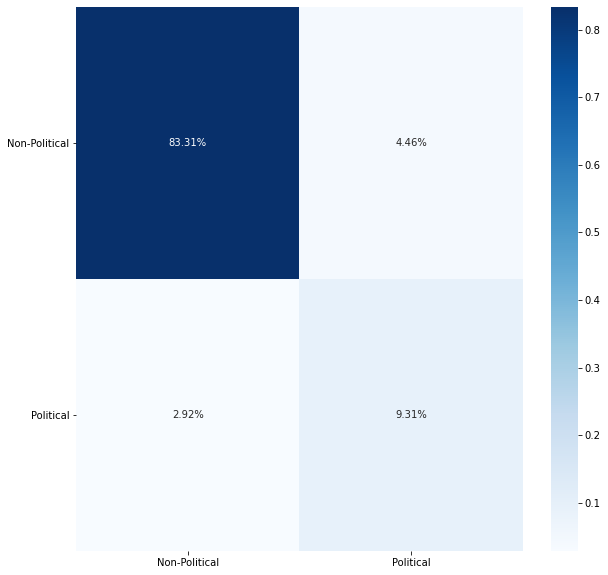

In [21]:
plt.figure(figsize=(10, 10))
print("f1_score: %.3f" % f1_score(y_true, y_pred_1))
ax = sns.heatmap(confuse_matrix_1/np.sum(confuse_matrix_1), cmap='Blues', annot=True, fmt='.2%')
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
plt.yticks(fontsize=10, rotation=0)
plt.xticks(fontsize=10, rotation=0);

f1_score: 0.711


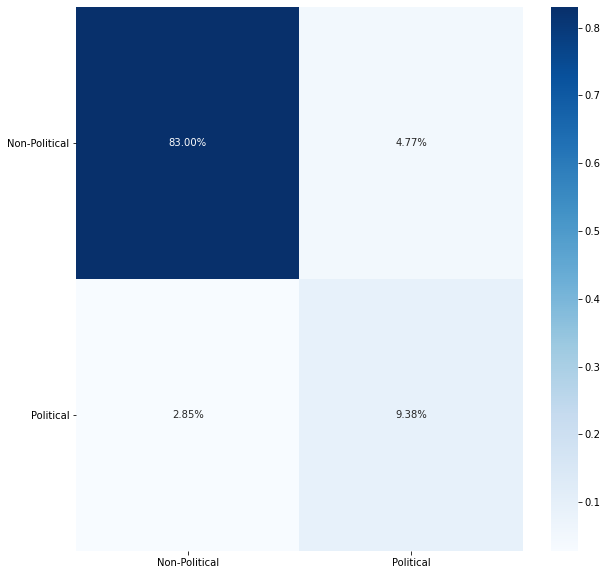

In [22]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confuse_matrix_2/np.sum(confuse_matrix_2), cmap='Blues', annot=True, fmt='.2%')
print("f1_score: %.3f" % f1_score(y_true, y_pred_2))
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
plt.yticks(fontsize=10, rotation=0)
plt.xticks(fontsize=10, rotation=0);

f1_score: 0.646


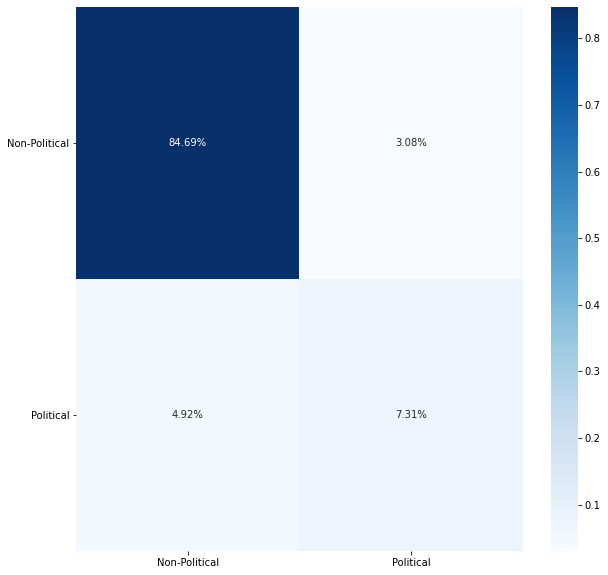

In [23]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(confuse_matrix_3/np.sum(confuse_matrix_3), cmap='Blues', annot=True, fmt='.2%')
print("f1_score: %.3f" % f1_score(y_true, y_pred_3))
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
plt.yticks(fontsize=10, rotation=0)
plt.xticks(fontsize=10, rotation=0);

In [24]:
twitter_df[['full_text', 'created_at', 'favorite_count', 'retweet_count', 'retweeted', 'id', 'possibly_sensitive']].iloc[0].apply(lambda x: len(x))

full_text             3000
created_at            3000
favorite_count        3000
retweet_count         3000
retweeted             3000
id                    3000
possibly_sensitive    3000
Name: 0, dtype: int64

In [25]:
twitter_df.dtypes

name                               object
screen_name                        object
followers_count                   float64
statuses_count                    float64
account_created_at    datetime64[ns, UTC]
full_text                          object
created_at                         object
favorite_count                     object
retweet_count                      object
retweeted                          object
id                                 object
possibly_sensitive                 object
filtered_tweets                    object
political_bools                    object
num_political                       int64
dtype: object

# Data Cleaning

Describe your data cleaning steps here.

Refer to the datacheckpoint notebook as the cleaning process takes up to half an hour to run depending on the machine. <br>
The data loaded in this notebook have already been cleaned

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

### Scatter Matrix of everything in the Twitter dataset

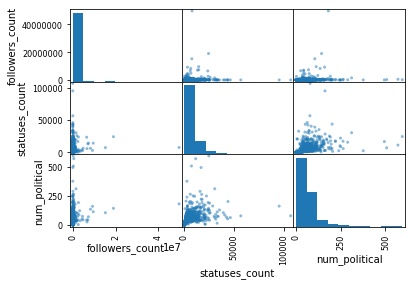

In [26]:
pd.plotting.scatter_matrix(twitter_df);

***The Overall Twitter data set can be observed to have various relationships, that can be explored more deeply, between the Follower Count, Status Count, and Number of Political Tweets by each Basket Ball Player. For example. the most noticeable being the relationship between a players number of political tweets and their status count***

### Scatter Matrix of Effective Game Percentage, Points, Salary, Total Rebounds, Assists, and Blocks

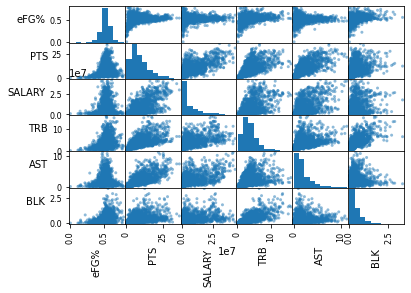

In [27]:
stats_data_df = pd.concat([df_2017, df_2018, df_2019, df_2020], axis=0)
stats_data_df = stats_data_df[['eFG%', 'PTS', 'SALARY', 'TRB', 'AST', 'BLK']]
axes = pd.plotting.scatter_matrix(stats_data_df);
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

***The Overall Main Data Set focused on player stats regarding Effective Game Percentage, Points, Total Rebounds, Assists, and Blocks from players in the NBA seems to have some real good relationships, that could be explored further. For example, Total Rebounds and the number of Blocks seem to be correlated in the sense that the more blocks a player has, the more total rebounds a player has as well***

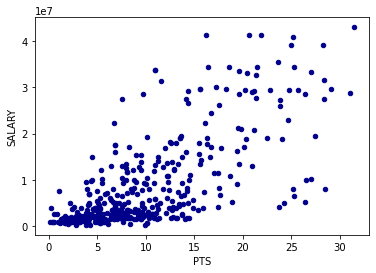

In [28]:
pts_salary_df = main_df[main_df['SEASON'] == '2020-21'][['PTS', 'SALARY']]

ax1 = pts_salary_df.plot.scatter(x= 'PTS', y = 'SALARY', c = 'DarkBlue')

### scatter plot, of number of points of all players  versus the overall number of political tweets for 2020 

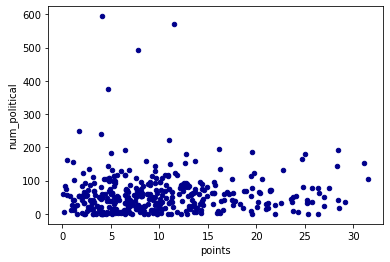

In [29]:
points_df = main_df[main_df['SEASON'] == '2020-21'][['PTS', 'NAME']]
points_df.columns = ['points', 'name']
political_tweets_df = twitter_df[['name', 'num_political']]
df = points_df.merge(political_tweets_df, how = 'inner')

ax1 = df.plot.scatter(x= 'points', y = 'num_political', c = 'DarkBlue')

this scatterplot shows whether or not theres a correlation between players that post political tweets and their average points scored per game

### Scatter plot of twitter followers of all players on x-axis, and salary on y-axis (influence of player on their salary) (Lauren)

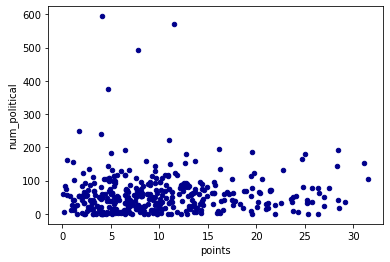

In [30]:
twitter_follow_df = twitter_df[['followers_count', 'name']]
twitter_follow_df.columns = ['FOLLOWERS', 'NAME']
political_tweets_df = twitter_df[['name', 'num_political']]
df = points_df.merge(political_tweets_df, how = 'inner')

ax1 = df.plot.scatter(x= 'points', y = 'num_political', c = 'DarkBlue')

this scatterplot shows if theres a correlation between the number of twitter followers a player has and their yearly salaries, we would use this to indicate the social influence a player has on their media platforms, if a player is more successful(higher salary) then they would be more influential (higher twitter following) meaning that if they made political posts they would theoretically get more support

### barplot of 10 players that has the most political tweets on the x-axis (Lauren)

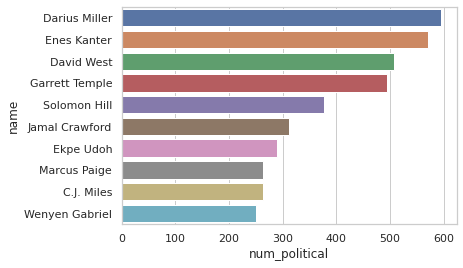

In [31]:
top_10 = twitter_df.sort_values(by='num_political', ascending=False).nlargest(10, 'num_political').reset_index(drop=True)
sns.set_theme(style = 'whitegrid')
sns.barplot(x='num_political', y = 'name', data = top_10);

### Line barplot by player of political tweets over the period of 2017-2021 for the top 3 earning players as of 2020

In [32]:
df_2020.sort_values(by='SALARY', ascending=False).nlargest

<bound method DataFrame.nlargest of       SEASON   AGE TEAM LEAGUE    POS     G    GS    MP    FG   FGA  ...  DRB  \
92   2020-21  32.0  GSW    NBA     PG  58.0  58.0  34.1  10.3  21.3  ...  5.1   
189  2020-21  32.0  WAS    NBA     PG  59.0  59.0  35.9   8.4  18.8  ...  9.6   
103  2020-21  35.0  PHO    NBA     PG  65.0  65.0  31.5   6.2  12.5  ...  4.1   
271  2020-21  30.0  HOU    NBA     PG  40.0  40.0  32.2   7.3  18.2  ...  2.8   
102  2020-21  31.0  TOT    NBA  PG,SG  42.0  42.0  37.1   8.0  17.2  ...  7.2   
..       ...   ...  ...    ...    ...   ...   ...   ...   ...   ...  ...  ...   
414  2020-21  23.0  PHI    NBA     PG  12.0   0.0   4.1   0.4   0.9  ...  0.7   
303  2020-21  26.0  TOR    NBA     SF  47.0   2.0  14.2   1.5   3.4  ...  2.4   
158  2020-21  23.0  CLE    NBA      C   8.0   0.0   9.5   1.3   2.3  ...  1.3   
305  2020-21  22.0  DET    NBA     PG  37.0   4.0  18.4   3.4   7.4  ...  1.8   
24   2020-21  26.0  POR    NBA     PF   9.0   1.0  10.2   0.9   1.9  ... 

In [33]:
top_three_earning_2020 = df_2020.sort_values(by='SALARY', ascending=False).nlargest(3, 'SALARY')
top_three_earning_2020

,SEASON,AGE,TEAM,LEAGUE,POS,G,GS,MP,FG,FGA,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,NAME,SALARY
92,2020-21,32.0,GSW,NBA,PG,58.0,58.0,34.1,10.3,21.3,...,5.1,5.6,5.7,1.2,0.1,3.4,1.9,31.5,Stephen Curry,43006362
189,2020-21,32.0,WAS,NBA,PG,59.0,59.0,35.9,8.4,18.8,...,9.6,11.3,11.3,1.4,0.4,4.9,2.8,21.9,Russell Westbrook,41358814
103,2020-21,35.0,PHO,NBA,PG,65.0,65.0,31.5,6.2,12.5,...,4.1,4.5,8.8,1.4,0.3,2.2,2.3,16.2,Chris Paul,41358814


In [34]:
names = top_three_earning_2020['NAME'].values.tolist()
df = twitter_df[(twitter_df['name'] == names[0]) | (twitter_df['name'] == names[1]) | (twitter_df['name'] == names[2])].reset_index(drop=True)
df = df.dropna(axis=0)
df

,name,screen_name,followers_count,statuses_count,account_created_at,full_text,created_at,favorite_count,retweet_count,retweeted,id,possibly_sensitive,filtered_tweets,political_bools,num_political
0,Stephen Curry,StephenCurry30,15267147.0,7485.0,2009-05-26 04:15:37+00:00,[RT @Dami0nLee: We jumped that man!! @StephenC...,"[2021-05-15 06:20:59+00:00, 2021-05-15 06:19:5...","[0, 19725, 0, 5780, 0, 24856, 0, 20854, 68716,...","[256, 1018, 59, 439, 248, 1735, 130, 1428, 661...","[False, False, False, False, False, False, Fal...","[1393451325803831298, 1393451046094004225, 139...","[nan, False, nan, False, nan, False, False, Fa...","[[dami0nle, :, jump, man, !, !, stephencurry30...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",105
1,Chris Paul,CP3,8297241.0,6428.0,2009-07-05 06:25:22+00:00,"[🤦🏾‍♂️🤷🏾‍♂️ https://t.co/YAy4C0iqqj, 🙏🏾💜💛 http...","[2021-05-17 03:56:51+00:00, 2021-05-16 00:45:3...","[5832, 12618, 0, 1733, 16369, 200, 0, 0, 8818,...","[346, 1105, 469, 88, 1495, 17, 19, 411, 478, 3...","[False, False, False, False, False, False, Fal...","[1394139828300566539, 1393729321810944005, 139...","[False, False, nan, False, False, False, nan, ...","[[🤦🏾‍♂️🤷🏾‍♂️, https, :, //t.co/yay4c0iqqj], [🙏...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...",135
2,Russell Westbrook,russwest44,6657614.0,5941.0,2009-04-28 03:59:26+00:00,[Tulsa Burning: The 1921 Race Massacre 5/30 at...,"[2021-04-27 18:31:07+00:00, 2021-03-20 00:48:3...","[7707, 1649, 2005, 6987, 8176, 0, 4233, 1535, ...","[2285, 129, 158, 812, 584, 141, 863, 134, 3320...","[False, False, False, False, False, False, Fal...","[1387112086011002881, 1373073953300873221, 136...","[False, False, False, False, False, nan, False...","[[tulsa, burn, :, 1921, race, massacr, 5/30, 8...","[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",26


In [35]:
tweet_dict = {'tweet_by_year': []}
years = [2017, 2018, 2019, 2020, 2021]
for idx, row in df.iterrows():
    temp = np.zeros(len(years))
    for j, date in enumerate(row['created_at']):
        if row['political_bools'][j] == 0:
            continue
        if date.year in years:
            temp[date.year - 2017] += 1
    tweet_dict['tweet_by_year'].append(temp.astype(np.int).tolist())

In [36]:
print(tweet_dict.values())

dict_values([[[10, 8, 12, 23, 14], [13, 14, 8, 32, 14], [0, 5, 0, 14, 4]]])


In [37]:
tweet_by_year_df = pd.DataFrame(tweet_dict['tweet_by_year'])
tweet_by_year_df.columns = years
df = pd.concat([df, tweet_by_year_df], axis=1)
df

,name,screen_name,followers_count,statuses_count,account_created_at,full_text,created_at,favorite_count,retweet_count,retweeted,id,possibly_sensitive,filtered_tweets,political_bools,num_political,2017,2018,2019,2020,2021
0,Stephen Curry,StephenCurry30,15267147.0,7485.0,2009-05-26 04:15:37+00:00,[RT @Dami0nLee: We jumped that man!! @StephenC...,"[2021-05-15 06:20:59+00:00, 2021-05-15 06:19:5...","[0, 19725, 0, 5780, 0, 24856, 0, 20854, 68716,...","[256, 1018, 59, 439, 248, 1735, 130, 1428, 661...","[False, False, False, False, False, False, Fal...","[1393451325803831298, 1393451046094004225, 139...","[nan, False, nan, False, nan, False, False, Fa...","[[dami0nle, :, jump, man, !, !, stephencurry30...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ...",105,10,8,12,23,14
1,Chris Paul,CP3,8297241.0,6428.0,2009-07-05 06:25:22+00:00,"[🤦🏾‍♂️🤷🏾‍♂️ https://t.co/YAy4C0iqqj, 🙏🏾💜💛 http...","[2021-05-17 03:56:51+00:00, 2021-05-16 00:45:3...","[5832, 12618, 0, 1733, 16369, 200, 0, 0, 8818,...","[346, 1105, 469, 88, 1495, 17, 19, 411, 478, 3...","[False, False, False, False, False, False, Fal...","[1394139828300566539, 1393729321810944005, 139...","[False, False, nan, False, False, False, nan, ...","[[🤦🏾‍♂️🤷🏾‍♂️, https, :, //t.co/yay4c0iqqj], [🙏...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, ...",135,13,14,8,32,14
2,Russell Westbrook,russwest44,6657614.0,5941.0,2009-04-28 03:59:26+00:00,[Tulsa Burning: The 1921 Race Massacre 5/30 at...,"[2021-04-27 18:31:07+00:00, 2021-03-20 00:48:3...","[7707, 1649, 2005, 6987, 8176, 0, 4233, 1535, ...","[2285, 129, 158, 812, 584, 141, 863, 134, 3320...","[False, False, False, False, False, False, Fal...","[1387112086011002881, 1373073953300873221, 136...","[False, False, False, False, False, nan, False...","[[tulsa, burn, :, 1921, race, massacr, 5/30, 8...","[0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...",26,0,5,0,14,4


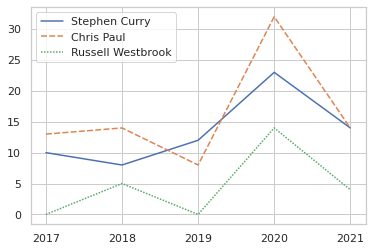

In [38]:
sns.lineplot(data=df[[2017, 2018, 2019, 2020, 2021]].T);
plt.xticks(np.arange(2017, 2022, 1));
plt.legend(df['name'].values);

There seems to be a peak in the number of political tweets in the year 2020. 
This makes sense as many politcal movements such as Black Lives Matter spur 
in the year of 2020 along with police brutality

### bi-boxplot: average of favorite count of nonpolitcal/political tweets for all players over 2017-2021 (Michael)

In [39]:
tweet_dict = {'political': [], 'nonpolitical': []}
years = [2017, 2018, 2019, 2020, 2021]
for idx, row in df.iterrows():
    political = np.zeros(len(years))
    nonpolitical = np.zeros(len(years))
    
    for j, date in enumerate(row['created_at']):
        if isinstance(date, datetime.datetime) and date.year in years:
            if row['political_bools'][j] == 0:
                nonpolitical[date.year - 2017] += row['favorite_count'][j]
            else:
                political[date.year - 2017] += row['favorite_count'][j]
    tweet_dict['political'].append(political.astype(np.int).tolist())
    tweet_dict['nonpolitical'].append(nonpolitical.astype(np.int).tolist())

In [40]:
df_political = pd.DataFrame(pd.DataFrame(tweet_dict['political']).sum(axis=0))
df_nonpolitical = pd.DataFrame(pd.DataFrame(tweet_dict['nonpolitical']).sum(axis=0))
df = pd.concat([df_political, df_nonpolitical], axis=1)
df.columns = ['political', 'nonpolitical']
df.index = years
df

,political,nonpolitical
2017,271134,5641965
2018,150475,5820920
2019,116186,4967849
2020,612596,4702887
2021,196131,2617933


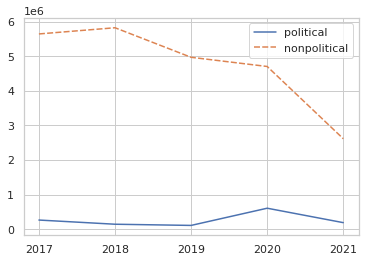

In [41]:
sns.lineplot(data=df);
plt.xticks(np.arange(2017, 2022, 1));

The plot shows that there is an increase in the number of favorite counts for both political and nonpolitical tweets 
in 2020. The plot can be further explored by looking at the average number of favorite count per year rather than
its total

### scatter plot of scoring of player vs number of political tweets for 2020 (Michael)

In [42]:
scoring_df = main_df[main_df['SEASON'] == '2020-21'][['PTS', 'NAME']]
scoring_df.columns= ['points', 'name']
political_tweet_df = twitter_df[['name', 'num_political']]
df = scoring_df.merge(political_tweet_df, how='inner')
df

,points,name,num_political
0,6.7,Kent Bazemore,45
1,5.1,DeAndre' Bembry,0
2,17.5,John Collins,42
3,8.1,Dewayne Dedmon,63
4,8.1,Dewayne Dedmon,63
...,...,...,...
408,13.8,Rui Hachimura,5
409,5.7,Garrison Mathews,50
410,2.3,Justin Robinson,61
411,5.2,Dylan Windler,16


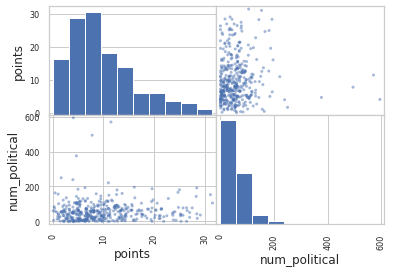

In [43]:
pd.plotting.scatter_matrix(df);

There does not seem to have a obvious correlation between points score and a player's political tweet, this might 
not necessarily be true as the two categorical variables have quite different scales and it's not normally distributed.
We can carry out inference test to be more confident about our conclustion.

## 